# START

In [85]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from scipy.fft import fft, ifft, fftshift, ifftshift
from scipy import signal

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

#simple forecasting
from statsforecast.models import HistoricAverage
from statsforecast.models import Naive

#ARIMA SARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# PROJECT STEPS

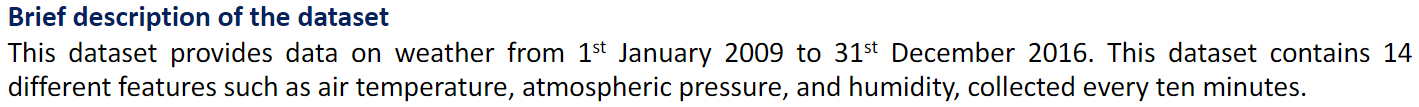

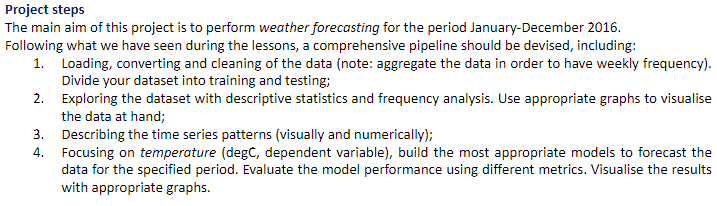

## Box-Jenkins method
When dealing with the family of ARIMA models, it is important to remember the **Box-Jenkins methodology** proposed by George Box and Gwilym Jenkins in their seminal book entitled *Time Series Analysis: Forecasting and Control* (1970) to find the best model. This refers to a systematic method of identifying, fitting, checking, and using ARIMA models built for time series forecasting. The approach starts with the assumption that the process that generated the time series can be approximated using a model from the ARIMA family. Starting from the available time series and use separate train/test sets, the process includes the following steps:

**1.   Model Identification:** as first step, it is important to verify the stationarity, determine if our time series is seasonal and find the seasonal period, and eventually apply appropriate transformations to reduce the variance (e.g., logarithm). When data have a strong seasonal pattern, seasonal differencing should be used as first step. Once stationarity and seasonality have been addressed, the next step is to identify the order (p,d,q) of ARIMA models in order to capture the salient dynamic features
of the data. This is usually done by relying on ACF/PACF plots or on grid search;

**2.   Model estimation:**  Once the model order has been identified, the model parameter are estimated generally using maximum likelihood estimation. Appropriate criteria, such as AIC, AICc and BIC, have to be used to compare and select the best model;

**3.   Model diagnostic:** After fitting the model on the train data, conduct goodness-of-fit checks to ensure the model describes the data adequately. In particular the residuals are taken and it is assessed whether they are white noise and they are normally distributed. ACF plot of the residuals can help in this respect, along with statistical tests as the Ljung-Box test.
If the assumed model is appropriate for the data, the residuals should satisfy these assumptions. If they are not satisfied, we have to go back to the model identification step and try to develop a better model;

**4.   Forecasting:** If the model is good, we can finally perform the forecasting analyses in the separate test set, and perform all the performance evalutations (e.g., MAE, MSE/RMSE, MAPE, R2).


# LOADING CONVERTING AND CLEANING OF THE DATA

## Load

In [2]:
Weather_data = pd.read_csv('Weather_ts.csv', sep=',', parse_dates=['Date Time'], date_format={'Date Time': '%d.%m.%Y %H:%M:%S'}, index_col='Date Time')
#with only the parser the data will not be datatime
#to resolve this problem i use the date_format
display(Weather_data.head(10))

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
2009-01-01 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
2009-01-01 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5


Variables 

-   1	Date Time		Date-time reference (INDEX)
-   2	p (mbar)		Pressure used to quantify internal pressure (in millibars) 
-   3	T (degC)		Temperature in Celsius
-   4	Tpot (K)	             Temperature in Kelvin
-   5	Tdew (degC)		Temperature in Celsius relative to humidity 
-   6	rh (%)		             Relative Humidity 
-   7	VPmax (mbar)	Saturation vapor pressure
-   8	VPact (mbar)		Vapor pressure
-   9	VPdef (mbar)		Vapor pressure deficit
-   10	sh (g/kg)		Specific humidity
-   11	H2OC (mmol/mol)	Water vapor concentration
-   12	rho (g/m**3)	             Airtight 
-   13	wv (m/s)		Wind speed
-   14	max. wv (m/s)	Maximum wind speed
-   15	wd (deg)		Wind direction in degrees


## Clean

In [3]:
#info
Weather_data.info() #no null values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420550 entries, 2009-01-01 00:10:00 to 2016-12-31 23:50:00
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         420550 non-null  float64
 1   T (degC)         420550 non-null  float64
 2   Tpot (K)         420550 non-null  float64
 3   Tdew (degC)      420550 non-null  float64
 4   rh (%)           420550 non-null  float64
 5   VPmax (mbar)     420550 non-null  float64
 6   VPact (mbar)     420550 non-null  float64
 7   VPdef (mbar)     420550 non-null  float64
 8   sh (g/kg)        420550 non-null  float64
 9   H2OC (mmol/mol)  420550 non-null  float64
 10  rho (g/m**3)     420550 non-null  float64
 11  wv (m/s)         420550 non-null  float64
 12  max. wv (m/s)    420550 non-null  float64
 13  wd (deg)         420550 non-null  float64
dtypes: float64(14)
memory usage: 48.1 MB


In [4]:
#second test null value
Weather_data.isna().sum() #no null values

p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

In [5]:
#columns
Weather_data.columns

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [6]:
Weather_data.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420550.000000,420550.000000,420550.000000,420550.000000,420550.000000,420550.000000,420550.000000,420550.000000,420550.000000,420550.000000,420550.000000,420550.000000,420550.000000,420550.000000
mean,989.212751,9.450181,283.492779,4.955886,76.008260,13.576273,9.533771,4.042419,6.022418,9.640238,1216.062557,1.702225,3.056558,174.743714
std,8.358475,8.423346,8.504449,6.730651,16.476195,7.739016,4.184158,4.896855,2.656135,4.235388,39.975064,65.446792,69.017014,86.681794
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


## Convert

we wnat to have weekly frequency

In [7]:
Weather_data.index

DatetimeIndex(['2009-01-01 00:10:00', '2009-01-01 00:20:00',
               '2009-01-01 00:30:00', '2009-01-01 00:40:00',
               '2009-01-01 00:50:00', '2009-01-01 01:00:00',
               '2009-01-01 01:10:00', '2009-01-01 01:20:00',
               '2009-01-01 01:30:00', '2009-01-01 01:40:00',
               ...
               '2016-12-31 22:20:00', '2016-12-31 22:30:00',
               '2016-12-31 22:40:00', '2016-12-31 22:50:00',
               '2016-12-31 23:00:00', '2016-12-31 23:10:00',
               '2016-12-31 23:20:00', '2016-12-31 23:30:00',
               '2016-12-31 23:40:00', '2016-12-31 23:50:00'],
              dtype='datetime64[ns]', name='Date Time', length=420550, freq=None)

In [8]:
Weather_data.index.year.unique()

Index([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], dtype='int32', name='Date Time')

In [9]:
Weather_data.index.month.unique()

Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int32', name='Date Time')

In [10]:
Weather_data.index.day.unique()

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype='int32', name='Date Time')

In [11]:
Weather_data.index.minute.unique()

Index([10, 20, 30, 40, 50, 0], dtype='int32', name='Date Time')

In [12]:
Weather_data.index.second.unique()

Index([0], dtype='int32', name='Date Time')

In [13]:
#convert the data time in weekly frequency
Weather_data_wk = Weather_data.resample('W').mean()
display(Weather_data_wk)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-04,996.446696,-4.292070,269.146087,-6.185148,87.255409,4.511496,3.918348,0.593009,2.451287,3.934887,1289.293165,1.293252,2.310504,177.589652
2009-01-11,999.146161,-11.057847,262.168393,-13.171438,84.714841,2.831081,2.369058,0.462044,1.477421,2.372718,1327.335734,1.312153,2.256984,158.967391
2009-01-18,991.308760,-1.717867,272.126657,-4.664692,81.310595,5.561796,4.483313,1.078720,2.820536,4.526012,1270.352133,1.879524,2.970417,178.882599
2009-01-25,970.486319,1.151438,276.681220,-1.678264,82.035218,6.752004,5.444335,1.307619,3.499306,5.613720,1230.040417,2.553998,3.973105,188.601022
2009-02-01,990.295337,-2.464573,271.454127,-3.848323,90.406944,5.104276,4.617619,0.486429,2.905952,4.663750,1272.179296,1.981885,3.170645,46.615129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-04,999.956121,-0.467679,272.701944,-3.387222,81.552579,6.156409,4.900109,1.256071,3.058046,4.906677,1275.453720,1.437123,2.741706,190.730853
2016-12-11,1000.134891,1.667212,274.823413,-1.334246,81.225665,7.381587,5.828373,1.553492,3.637927,5.834554,1265.589107,1.437609,2.601359,182.925089
2016-12-18,1002.300288,2.645923,275.628373,1.012192,89.163800,7.507450,6.704841,0.802490,4.174643,6.694365,1262.940823,1.418085,2.399752,185.361032


## Divide dataset into training and testing

The main aim of this project is to perform weather forecasting for the period January-December 2016.

In [14]:
#train everything before january 2016
Weather_data_wk_train = Weather_data_wk[Weather_data_wk.index < '2016-01-01']
Weather_data_wk_test = Weather_data_wk[Weather_data_wk.index >= '2016-01-01']

display(Weather_data_wk_train.index.year.unique())
display(Weather_data_wk_test.index.year.unique())

Index([2009, 2010, 2011, 2012, 2013, 2014, 2015], dtype='int32', name='Date Time')

Index([2016, 2017], dtype='int32', name='Date Time')

# EXPLORING THE DATASET

## Descriptive Statistic

fare .describe e fare gli histogrammi

In [15]:
display(Weather_data_wk)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-04,996.446696,-4.292070,269.146087,-6.185148,87.255409,4.511496,3.918348,0.593009,2.451287,3.934887,1289.293165,1.293252,2.310504,177.589652
2009-01-11,999.146161,-11.057847,262.168393,-13.171438,84.714841,2.831081,2.369058,0.462044,1.477421,2.372718,1327.335734,1.312153,2.256984,158.967391
2009-01-18,991.308760,-1.717867,272.126657,-4.664692,81.310595,5.561796,4.483313,1.078720,2.820536,4.526012,1270.352133,1.879524,2.970417,178.882599
2009-01-25,970.486319,1.151438,276.681220,-1.678264,82.035218,6.752004,5.444335,1.307619,3.499306,5.613720,1230.040417,2.553998,3.973105,188.601022
2009-02-01,990.295337,-2.464573,271.454127,-3.848323,90.406944,5.104276,4.617619,0.486429,2.905952,4.663750,1272.179296,1.981885,3.170645,46.615129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-04,999.956121,-0.467679,272.701944,-3.387222,81.552579,6.156409,4.900109,1.256071,3.058046,4.906677,1275.453720,1.437123,2.741706,190.730853
2016-12-11,1000.134891,1.667212,274.823413,-1.334246,81.225665,7.381587,5.828373,1.553492,3.637927,5.834554,1265.589107,1.437609,2.601359,182.925089
2016-12-18,1002.300288,2.645923,275.628373,1.012192,89.163800,7.507450,6.704841,0.802490,4.174643,6.694365,1262.940823,1.418085,2.399752,185.361032


### Plot

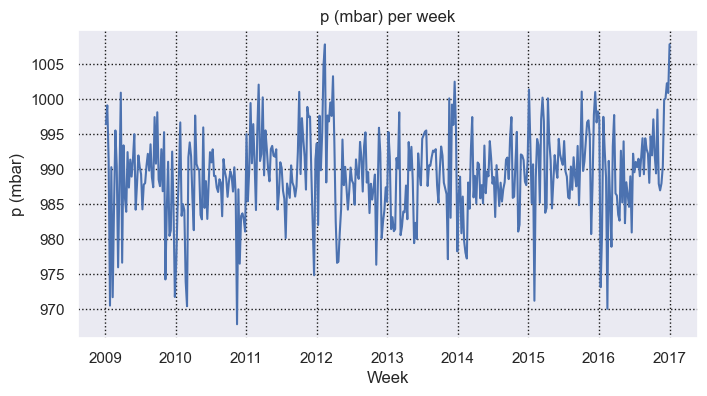

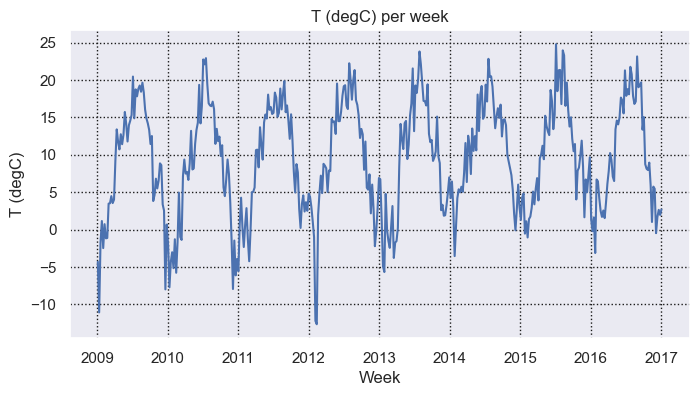

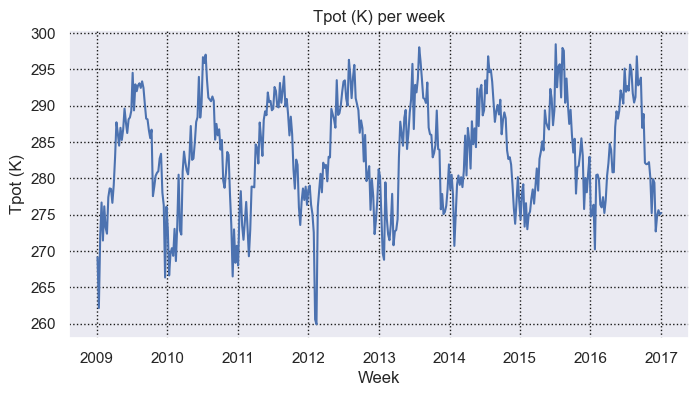

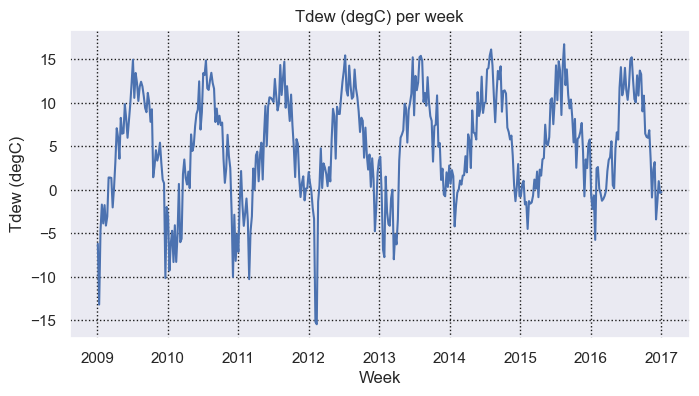

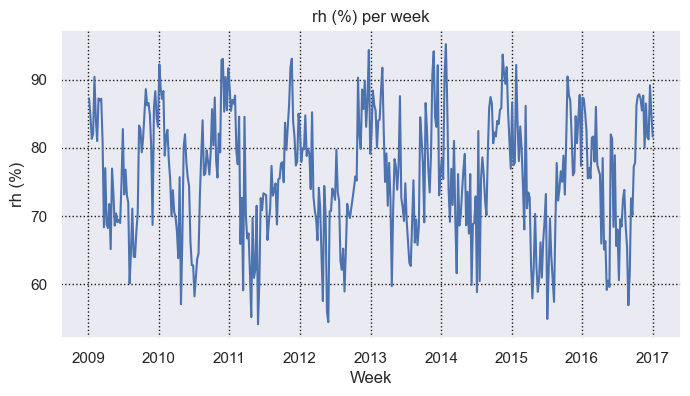

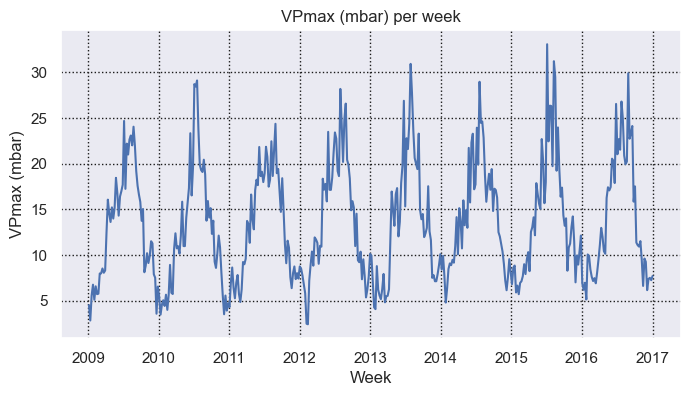

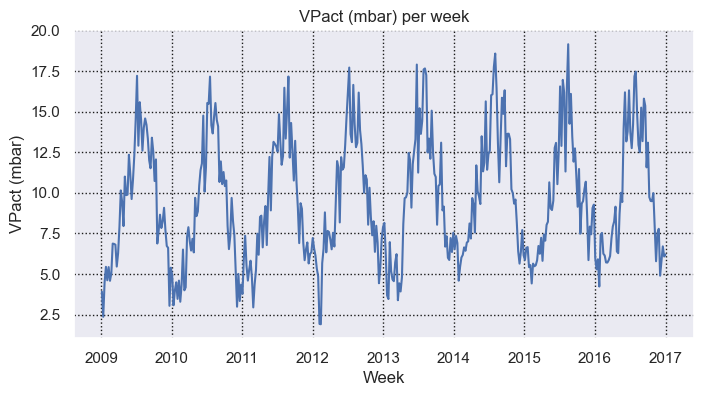

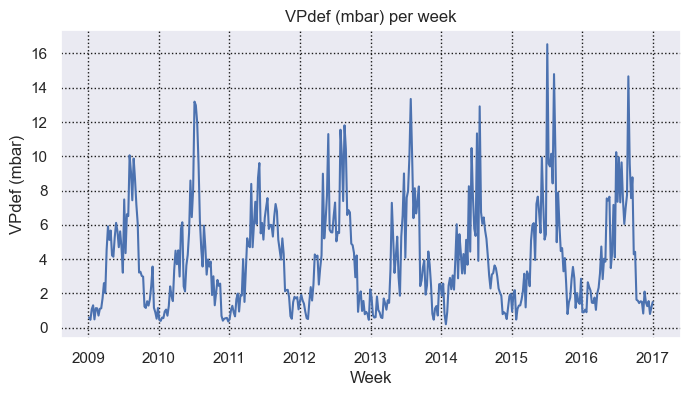

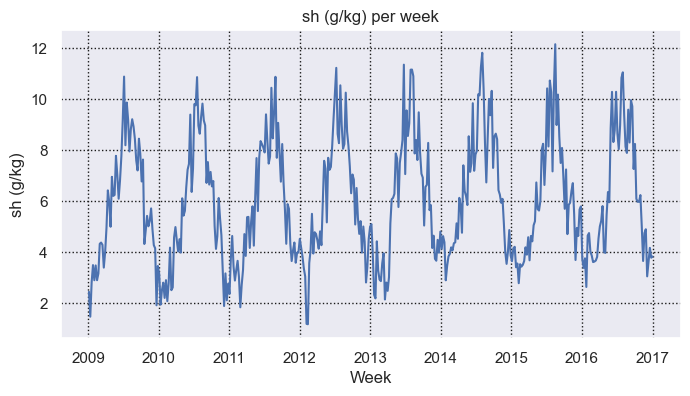

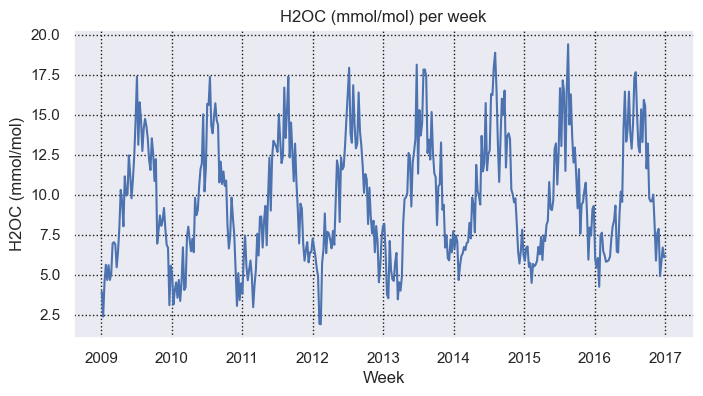

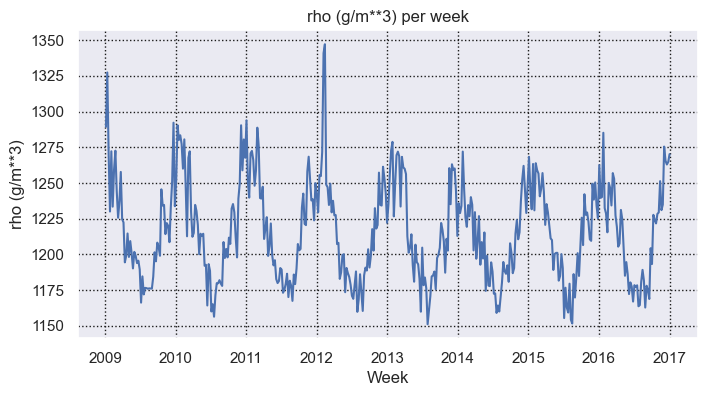

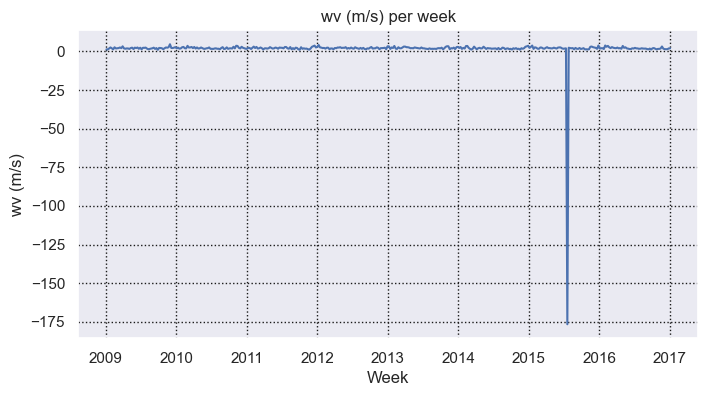

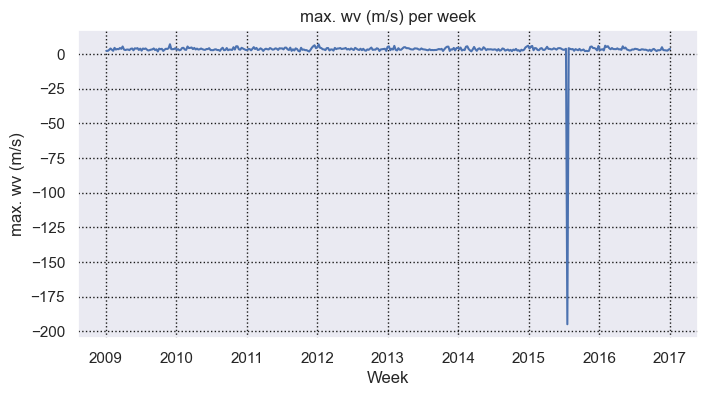

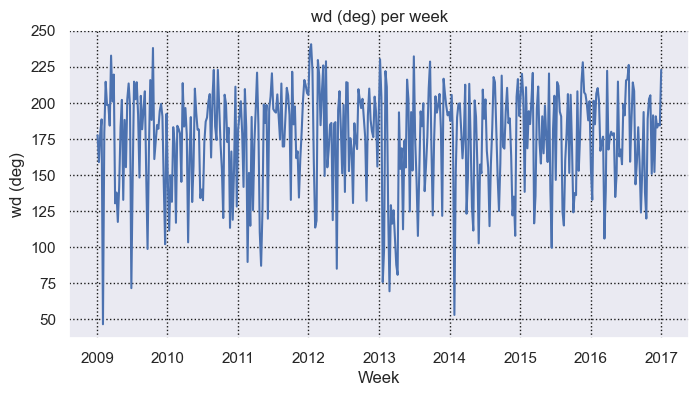

In [16]:
# plot all the data
for column in Weather_data_wk.columns:
    plt.figure(figsize=(8,4))
    plt.plot(Weather_data_wk[column])
    plt.grid(True, color = 'k', linestyle = ':')
    plt.title(column + ' per week')
    plt.xlabel('Week')
    plt.ylabel(column)

probabile outliers in max????? controllare

### Heatmap

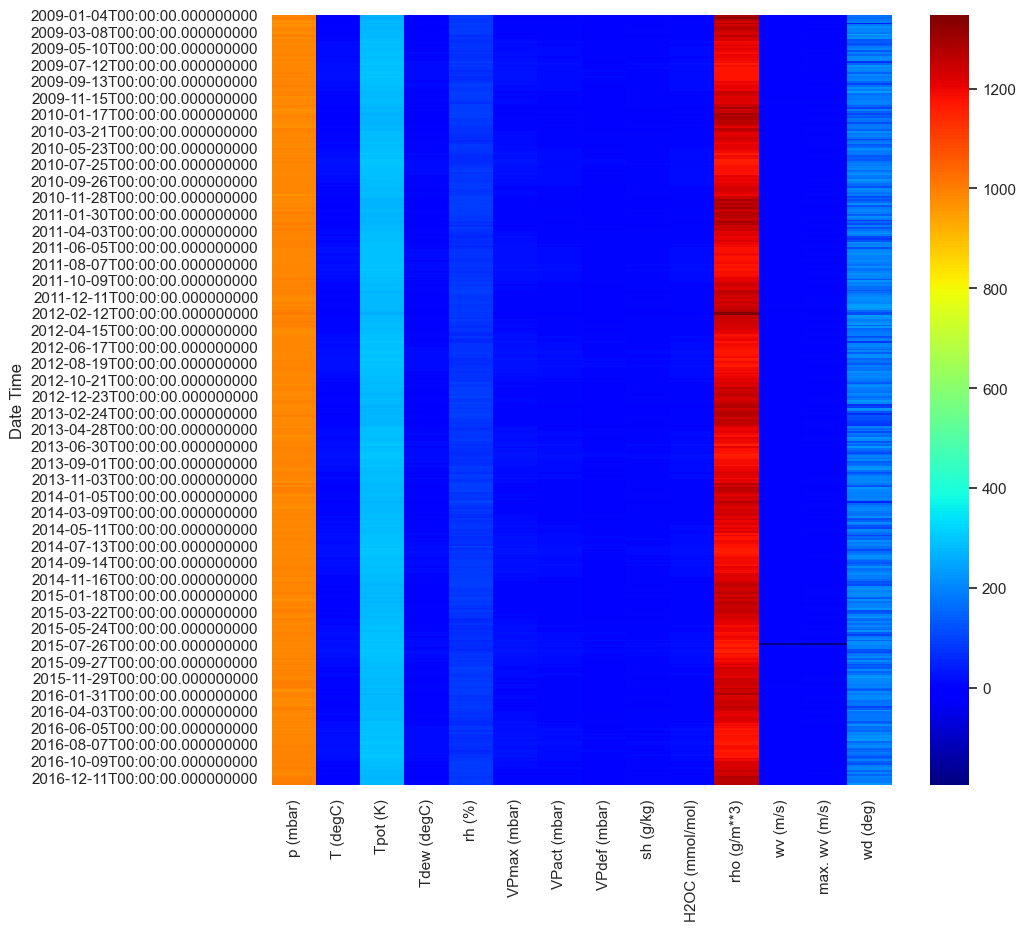

In [17]:
#heatmap
plt.figure(figsize=(10,10))
sns.heatmap(Weather_data_wk, cmap='jet')
plt.show()

### Boxplot

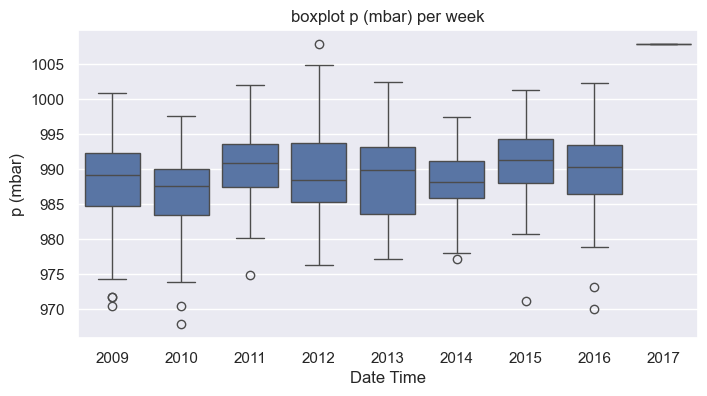

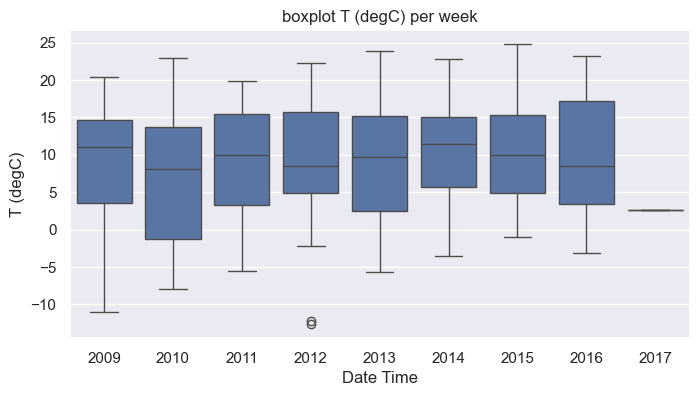

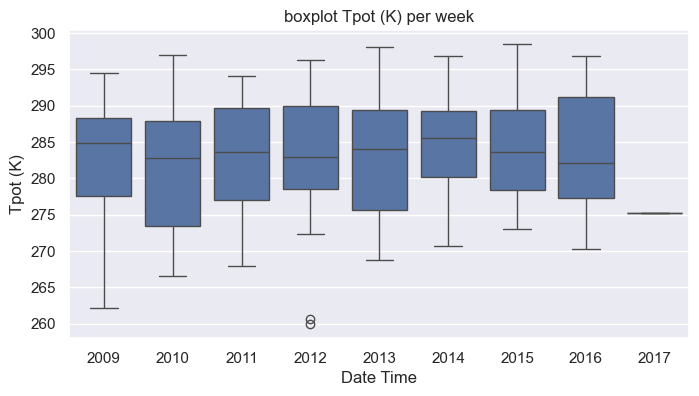

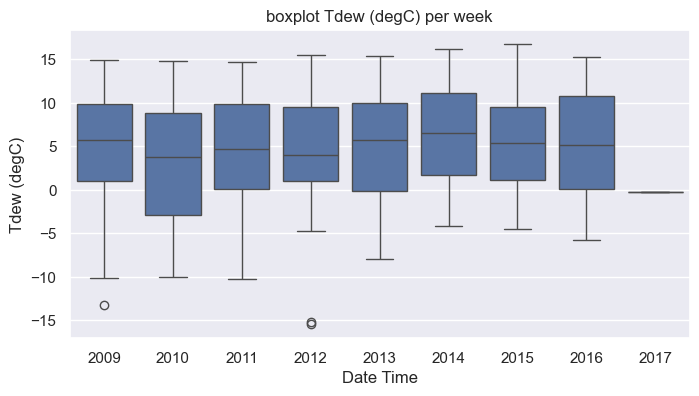

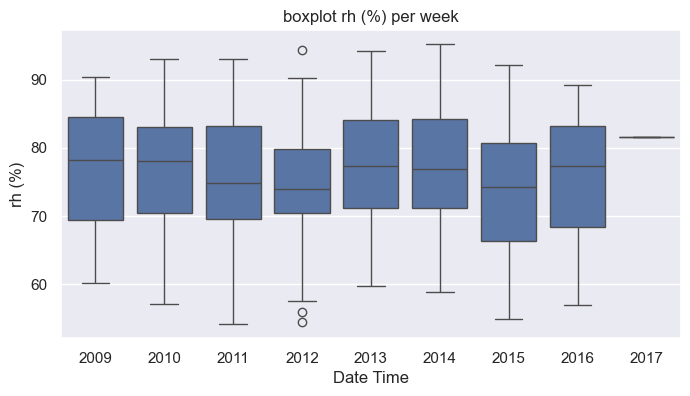

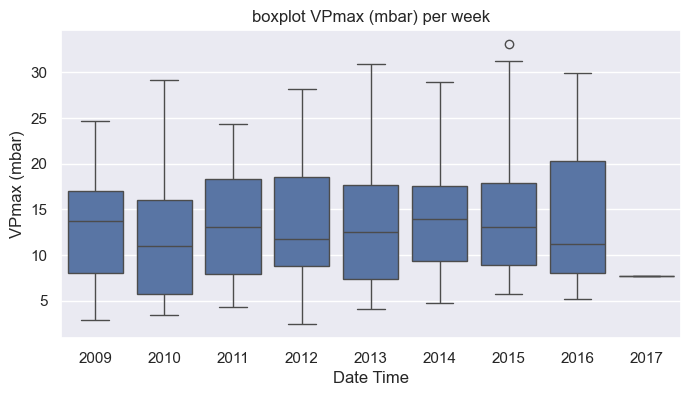

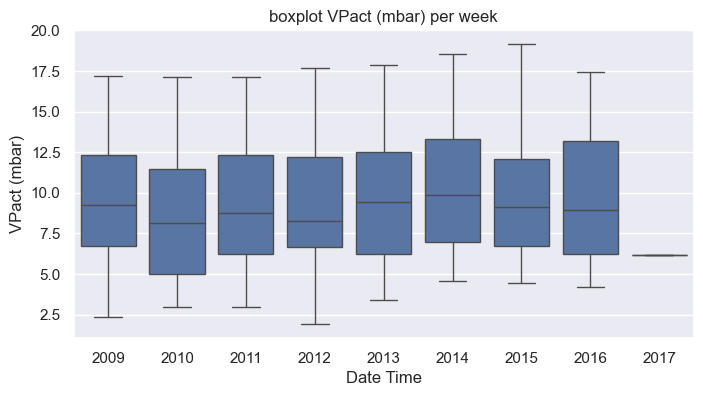

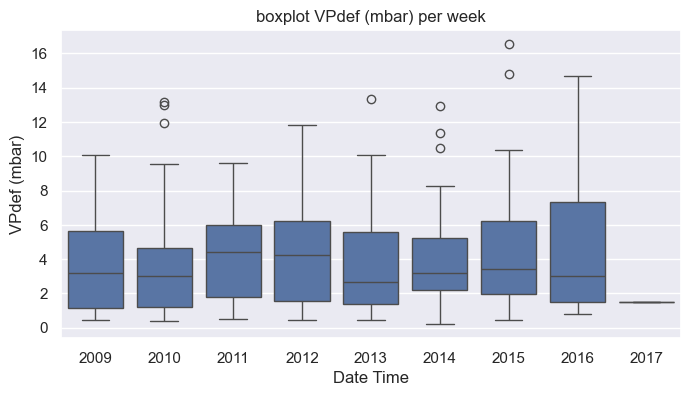

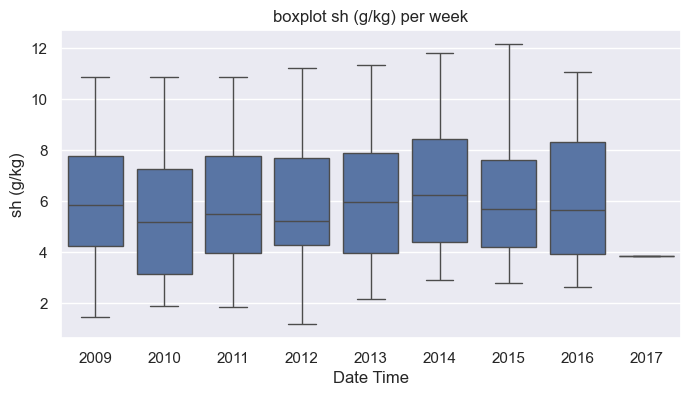

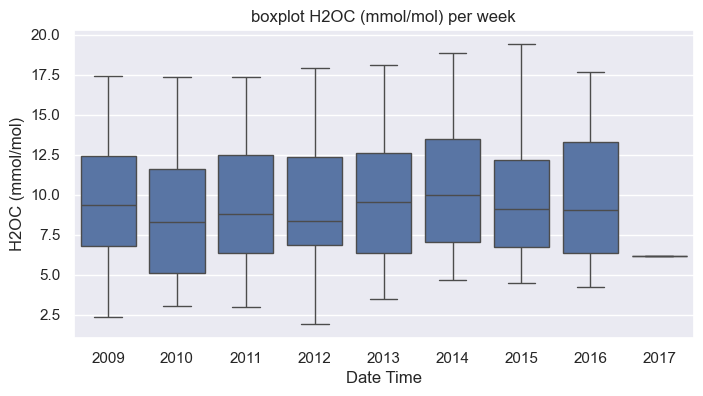

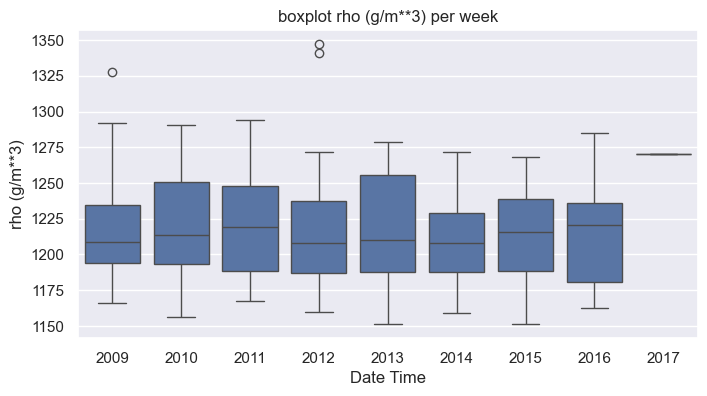

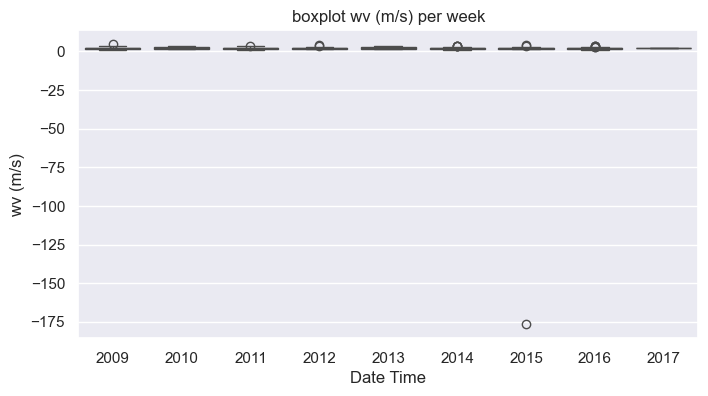

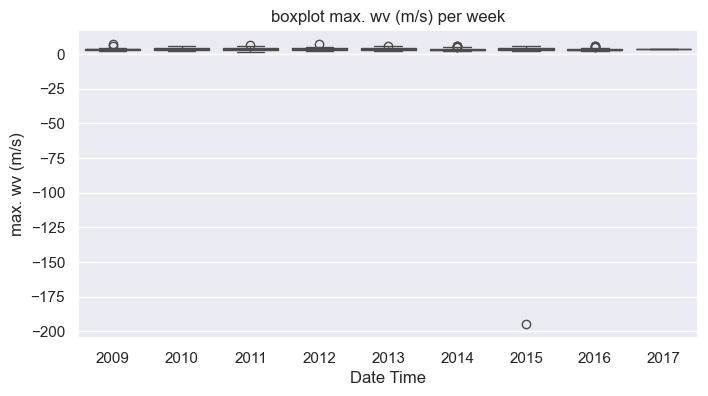

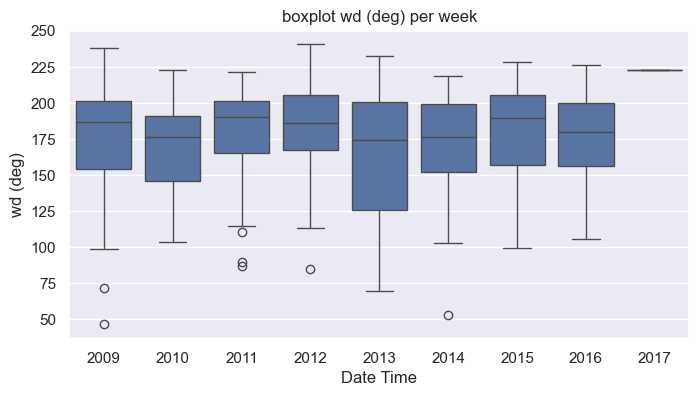

In [18]:
#Boxplot
# plot all the data
for column in Weather_data_wk.columns:
    plt.figure(figsize=(8,4))
    #plt.plot(Weather_data_wk[column])
    #plt.grid(True, color = 'k', linestyle = ':')
    plt.title('boxplot ' + column + ' per week')
    #plt.xlabel('Week')
    #plt.ylabel(column)
    sns.boxplot(x = Weather_data_wk.index.year, y = Weather_data_wk[column])
    plt.show()

outliers in wv

### Outliers

i decide to use the standard deviation method

In [19]:
for column in Weather_data_wk.columns:
    print('---------------------------')
    print(f'Outlier with standard deviation method for {column}')
    mean_value = np.mean(Weather_data_wk[column]) #calcolo la media
    sd_value = np.std(Weather_data_wk[column]) #calcolo lo sd
    thr = 3*sd_value 
    Lower = mean_value - thr
    Upper = mean_value + thr

    outliers = [i for i in Weather_data_wk[column] if i < Lower or i > Upper] #prendo tutti i valori fuori dal limite -> outlier
    print('Number of outliers:', len(outliers))
    print('Outliers:', outliers)

    P_no_outliers = [i for i in Weather_data_wk[column] if i > Lower and i < Upper]
    print('Number of non-outliers:', len(P_no_outliers))

---------------------------
Outlier with standard deviation method for p (mbar)
Number of outliers: 5
Outliers: [970.4863194444445, 970.3948611111111, 967.8167956349206, 970.0243253968254, 1007.8895486111111]
Number of non-outliers: 413
---------------------------
Outlier with standard deviation method for T (degC)
Number of outliers: 0
Outliers: []
Number of non-outliers: 418
---------------------------
Outlier with standard deviation method for Tpot (K)
Number of outliers: 2
Outliers: [260.60050595238096, 259.93815476190474]
Number of non-outliers: 416
---------------------------
Outlier with standard deviation method for Tdew (degC)
Number of outliers: 2
Outliers: [-15.153799603174603, -15.437232142857143]
Number of non-outliers: 416
---------------------------
Outlier with standard deviation method for rh (%)
Number of outliers: 0
Outliers: []
Number of non-outliers: 418
---------------------------
Outlier with standard deviation method for VPmax (mbar)
Number of outliers: 1
Outlie

come possiamo vedere in wm e max wm abbiamo trovato gli outlier maggiori 

Per quanto rigurda la temperatura in C non abbiamo trovato outliers

### Correlation

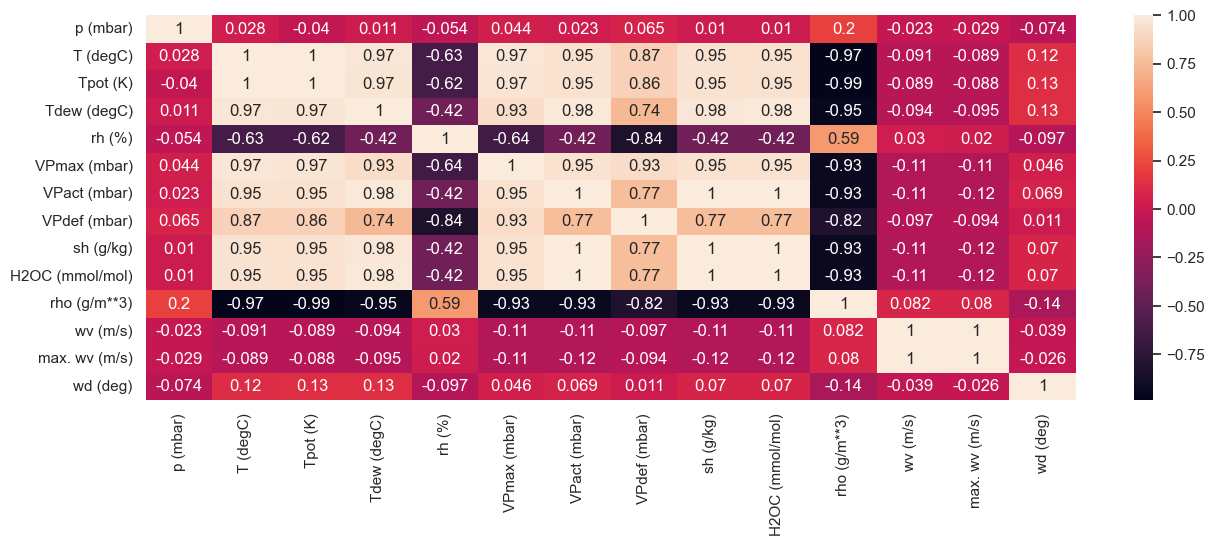

In [20]:
plt.figure(figsize=(15,5))
sns.heatmap(Weather_data_wk.corr(), annot=True)
plt.show()

METTERE EFFETIVAMNETE UNA DESCRIZIONE

### Autocorrelation

MI SA CHE TOLGO QUESTA PARTE, QUA è INUTILE SERVE IN THE DESCIBING TIME SERIES

In [21]:
'''# plot all the data
for column in Weather_data_wk.columns:
    plt.figure(figsize=(8,4))
    plot_acf(Weather_data_wk[column], lags=12)
    plt.title('Autocorrelation function for ' + column)
    plt.xlabel('LAG??')
    plt.ylabel('Autocorrelation')
    plt.show()
    
#matplotlib.pyplot.close()'''

"# plot all the data\nfor column in Weather_data_wk.columns:\n    plt.figure(figsize=(8,4))\n    plot_acf(Weather_data_wk[column], lags=12)\n    plt.title('Autocorrelation function for ' + column)\n    plt.xlabel('LAG??')\n    plt.ylabel('Autocorrelation')\n    plt.show()\n    \n#matplotlib.pyplot.close()"

per la maggior parte abbiamo un seasonality che si ripete ogni 1 mese/ 1 lag, in più la autocorrelazione è sempre positiva (RIVEDER)

## Frequency Analysis


vedere la lezione 6 fatta dalla prof

solo sulla temperatura

### FFT and Amplitude Spectrum

In [22]:
'''# FFT and Amplitude Spectrum
for column in Weather_data_wk_train.columns:
    Fs = 1 # sampling rate, our unit of measure is "months" (Important!) --> the data are sampled monthly, thus the sampling rate is 1 sample per month
    X = fft(Weather_data_wk_train[column].values)
    N = len(X)
    freq_step = Fs/N
    freq_vec = np.arange(0,Fs,freq_step)

    ampl = np.abs(X[1:])/N # Start from 1 to remove the zero frequency component, called DC
    freq_vec = freq_vec[1:]
    plt.plot(freq_vec,ampl)
    plt.title(f'Double Sided FFT for {column}')
    plt.xlabel('Frequency')
    plt.ylabel('FFT Amplitude |X(freq)|')
    plt.show()'''

'# FFT and Amplitude Spectrum\nfor column in Weather_data_wk_train.columns:\n    Fs = 1 # sampling rate, our unit of measure is "months" (Important!) --> the data are sampled monthly, thus the sampling rate is 1 sample per month\n    X = fft(Weather_data_wk_train[column].values)\n    N = len(X)\n    freq_step = Fs/N\n    freq_vec = np.arange(0,Fs,freq_step)\n\n    ampl = np.abs(X[1:])/N # Start from 1 to remove the zero frequency component, called DC\n    freq_vec = freq_vec[1:]\n    plt.plot(freq_vec,ampl)\n    plt.title(f\'Double Sided FFT for {column}\')\n    plt.xlabel(\'Frequency\')\n    plt.ylabel(\'FFT Amplitude |X(freq)|\')\n    plt.show()'

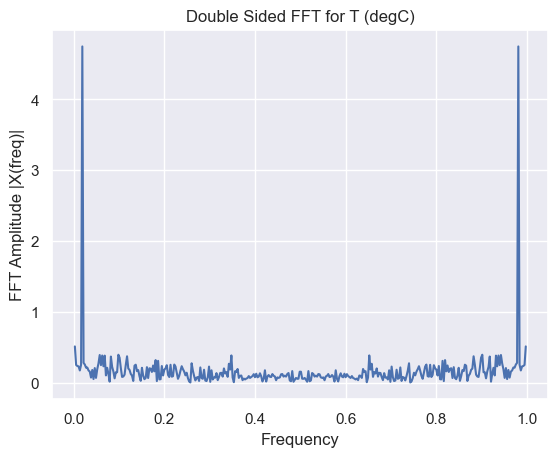

In [23]:
Fs = 1 # sampling rate, our unit of measure is "months" (Important!) --> the data are sampled monthly, thus the sampling rate is 1 sample per month
X = fft(Weather_data_wk_train['T (degC)'].values)
N = len(X)
freq_step = Fs/N
freq_vec = np.arange(0,Fs,freq_step)

ampl = np.abs(X[1:])/N # Start from 1 to remove the zero frequency component, called DC
freq_vec = freq_vec[1:]
plt.plot(freq_vec,ampl)
plt.title(f'Double Sided FFT for T (degC)')
plt.xlabel('Frequency')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.show()

### Power Spectral Density (PSD)

### Power Spectral Density (PSD) based on Periodgram

#### test 1

In [24]:
'''#create a dizio to save the period
dizio_period = {}

for column in Weather_data_wk.columns:
    ###Retrieve the seasonlity by using the periodogram and getting the most used frequencies.
    f_per, Pxx_per = signal.periodogram(Weather_data_wk[column],1,detrend=None,window='hann',return_onesided=True,scaling='density')
    f_per = f_per[1:]
    Pxx_per = Pxx_per[1:]

    #Find the peaks of the periodogram.
    #peaks = signal.find_peaks(Pxx_per[f_per >= 0], prominence=(Pxx_per) * 0.001)[0]
    peaks = signal.find_peaks(Pxx_per[f_per >= 0])[0]
    peak_freq = f_per[peaks]
    peak_dens = Pxx_per[peaks]

    #Plot of the analysis transformation and of its peaks. Only the first five are interestings
    fig = plt.figure(figsize=(16,6))
    plt.plot(peak_freq, peak_dens, 'ro')
    plt.plot(f_per[2:],Pxx_per[2:])
    plt.xlabel('Frequency')
    plt.ylabel('Density')
    plt.title(f'PSD using periodgram for {column}')
    plt.show()

    #Retrieving of the values
    data = {'Frequency': peak_freq, 'Density': peak_dens, 'Period': 1/peak_freq}
    df = pd.DataFrame(data) #ATTENZIONE ORDINARE PER DENISTA
    df.sort_values('Density', ascending=False, inplace=True, ignore_index=True)
    display(df.head()) #come possimao vedere il più frequete è 12

    dizio_period[column] = df.loc[0,'Period']'''


"#create a dizio to save the period\ndizio_period = {}\n\nfor column in Weather_data_wk.columns:\n    ###Retrieve the seasonlity by using the periodogram and getting the most used frequencies.\n    f_per, Pxx_per = signal.periodogram(Weather_data_wk[column],1,detrend=None,window='hann',return_onesided=True,scaling='density')\n    f_per = f_per[1:]\n    Pxx_per = Pxx_per[1:]\n\n    #Find the peaks of the periodogram.\n    #peaks = signal.find_peaks(Pxx_per[f_per >= 0], prominence=(Pxx_per) * 0.001)[0]\n    peaks = signal.find_peaks(Pxx_per[f_per >= 0])[0]\n    peak_freq = f_per[peaks]\n    peak_dens = Pxx_per[peaks]\n\n    #Plot of the analysis transformation and of its peaks. Only the first five are interestings\n    fig = plt.figure(figsize=(16,6))\n    plt.plot(peak_freq, peak_dens, 'ro')\n    plt.plot(f_per[2:],Pxx_per[2:])\n    plt.xlabel('Frequency')\n    plt.ylabel('Density')\n    plt.title(f'PSD using periodgram for {column}')\n    plt.show()\n\n    #Retrieving of the values\n  

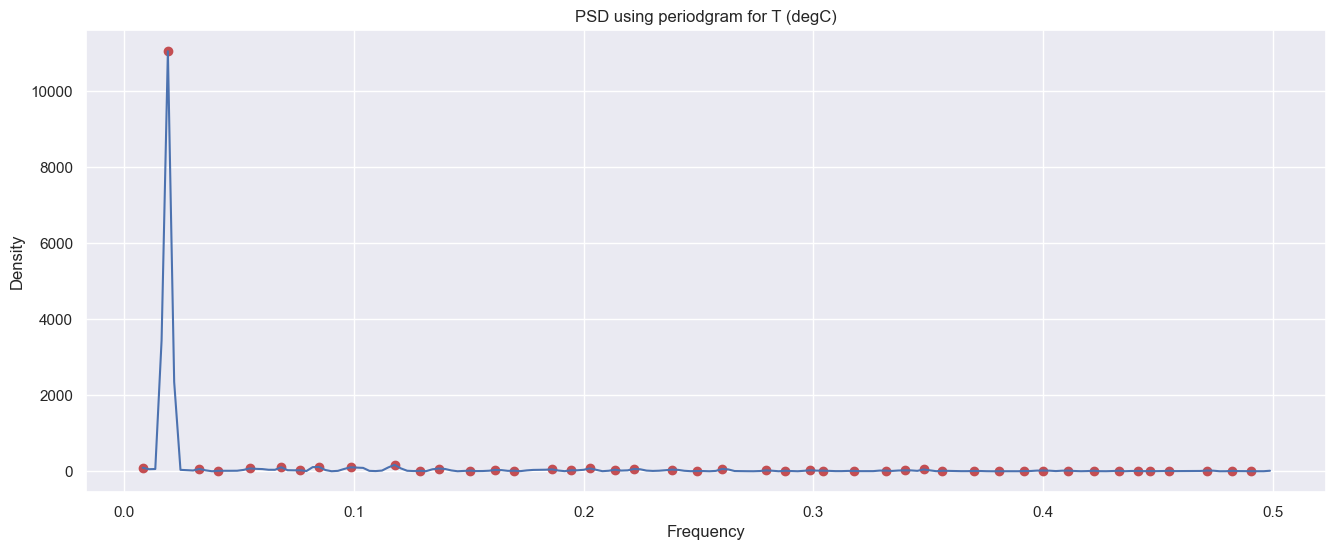

,Frequency,Density,Period
0,0.019178,11059.782553,52.142857
1,0.117808,169.316720,8.488372
2,0.084932,113.229485,11.774194
3,0.068493,105.509285,14.600000
4,0.098630,103.482978,10.138889


In [25]:
#create a dizio to save the period
dizio_period = {}


###Retrieve the seasonlity by using the periodogram and getting the most used frequencies.
f_per, Pxx_per = signal.periodogram(Weather_data_wk_train['T (degC)'], 1, detrend=None, window='hann', return_onesided=True, scaling='density')
f_per = f_per[1:]
Pxx_per = Pxx_per[1:]

#Find the peaks of the periodogram.
#peaks = signal.find_peaks(Pxx_per[f_per >= 0], prominence=(Pxx_per) * 0.001)[0]
peaks = signal.find_peaks(Pxx_per[f_per >= 0])[0]
peak_freq = f_per[peaks]
peak_dens = Pxx_per[peaks]

#Plot of the analysis transformation and of its peaks. Only the first five are interestings
fig = plt.figure(figsize=(16,6))
plt.plot(peak_freq, peak_dens, 'ro')
plt.plot(f_per[2:],Pxx_per[2:])
plt.xlabel('Frequency')
plt.ylabel('Density')
plt.title(f'PSD using periodgram for T (degC)')
plt.show()

#Retrieving of the values
data = {'Frequency': peak_freq, 'Density': peak_dens, 'Period': 1/peak_freq}
df = pd.DataFrame(data) #ATTENZIONE ORDINARE PER DENISTA
df.sort_values('Density', ascending=False, inplace=True, ignore_index=True)
display(df.head()) #come possimao vedere il più frequete è 12

dizio_period['T (degC)'] = df.loc[0,'Period']

In [26]:
dizio_period

{'T (degC)': 52.14285714285714}

#### test 2

In [27]:
'''for column in Weather_data_wk:
    # (Optional) Check with the frequency analysis (PSD) the frequency of the time series (train data), to conferm the seasonality value to be included in the forecasting
    Fs = 1 # our unit of measures is "months", thus 1 per month
    f_per, Pxx_per = signal.periodogram(Weather_data_wk[column],Fs,detrend=False,window='boxcar',return_onesided=True,scaling='density')
    f_per = f_per[1:]
    Pxx_per = Pxx_per[1:]
    plt.plot(f_per,Pxx_per)
    plt.xlabel('Frequency [cycles/month]')
    plt.title(column)

    peaks = signal.find_peaks(Pxx_per[f_per >=0], prominence=100)[0]
    peak_freq =  f_per[peaks]
    peak_power = Pxx_per[peaks]
    plt.plot(peak_freq, peak_power, 'ro')
    plt.show()

    data = {'Freq': peak_freq, 'Period': 1/peak_freq, 'Power': peak_power}
    df = pd.DataFrame(data)
    display(df)'''

'for column in Weather_data_wk:\n    # (Optional) Check with the frequency analysis (PSD) the frequency of the time series (train data), to conferm the seasonality value to be included in the forecasting\n    Fs = 1 # our unit of measures is "months", thus 1 per month\n    f_per, Pxx_per = signal.periodogram(Weather_data_wk[column],Fs,detrend=False,window=\'boxcar\',return_onesided=True,scaling=\'density\')\n    f_per = f_per[1:]\n    Pxx_per = Pxx_per[1:]\n    plt.plot(f_per,Pxx_per)\n    plt.xlabel(\'Frequency [cycles/month]\')\n    plt.title(column)\n\n    peaks = signal.find_peaks(Pxx_per[f_per >=0], prominence=100)[0]\n    peak_freq =  f_per[peaks]\n    peak_power = Pxx_per[peaks]\n    plt.plot(peak_freq, peak_power, \'ro\')\n    plt.show()\n\n    data = {\'Freq\': peak_freq, \'Period\': 1/peak_freq, \'Power\': peak_power}\n    df = pd.DataFrame(data)\n    display(df)'

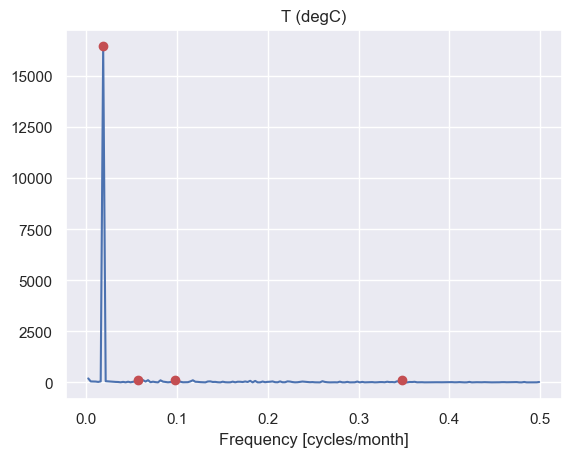

,Freq,Period,Power
0,0.019178,52.142857,16456.709324
1,0.057534,17.380952,112.708219
2,0.098630,10.138889,115.229860
3,0.347945,2.874016,109.511200


In [28]:
# (Optional) Check with the frequency analysis (PSD) the frequency of the time series (train data), to conferm the seasonality value to be included in the forecasting
Fs = 1 # our unit of measures is "months", thus 1 per month
f_per, Pxx_per = signal.periodogram(Weather_data_wk_train['T (degC)'], Fs, detrend=False, window='boxcar', return_onesided=True, scaling='density')
f_per = f_per[1:]
Pxx_per = Pxx_per[1:]
plt.plot(f_per,Pxx_per)
plt.xlabel('Frequency [cycles/month]')
plt.title('T (degC)')

peaks = signal.find_peaks(Pxx_per[f_per >=0], prominence=100)[0]
peak_freq =  f_per[peaks]
peak_power = Pxx_per[peaks]
plt.plot(peak_freq, peak_power, 'ro')
plt.show()

data = {'Freq': peak_freq, 'Period': 1/peak_freq, 'Power': peak_power}
df = pd.DataFrame(data)
display(df)

# DESCRIBING THE TIME SERIES PATTERS

In [29]:
temp = Weather_data_wk_train['T (degC)']

## Stationarity

first we have to check the stationary of the time series, we do this becouse many statistical model require the series to be stationary to make effective and precise predictions. 
To check the stationary we can:
-   check mean and standard deviation (have to be constant over the time)
-   use the ACF (we can also spot presence of seasonality or trend)
-   statistical hypotesis test like ADF and KPSS

### Check mean and standard deviation (Rolling statistics)

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

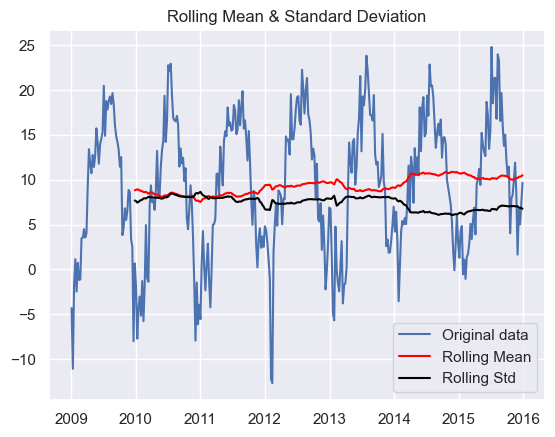

In [30]:
rolling_mean = temp.rolling(52).mean() #parameter window -> contain the lsat 52 observation (so 1 year) and calculate the mean  (CREDO)
rolling_std = temp.rolling(52).std()
plt.plot(temp, label='Original data')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

Like we can see form the plot the mean start to increse during the time so it is mean that maybe the series is not stationary also we see a cycle that it repeat every year.

For the standard deviation we can see that have a constant behaviour over the years maybe a small decline (mmm forse è sbagliato, sembra che il trend a standard deviation siamo inversamente proporzionali??)

### ACF and PACF

can be use to identify possible components of the time series and understand if the ts can be stationary or not??

Note: we know from frequancy analysis that for the feature T (dec) the seasonal periond is equal to 52

ACF and PACF for non-seasonal part (AR) 

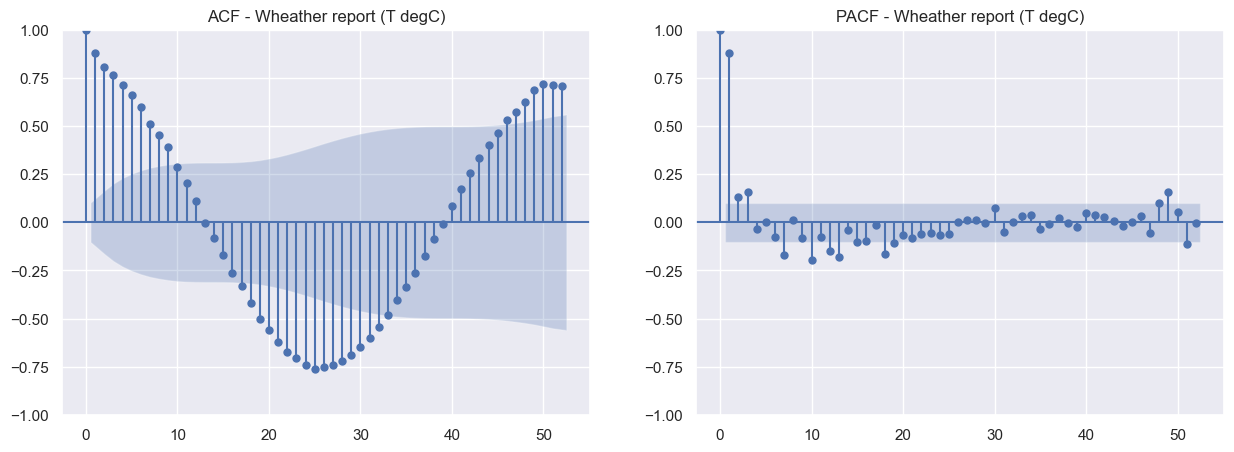

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
plot_acf(temp, lags=52, ax=ax[0], title='ACF - Wheather report (T degC)')
plot_pacf(temp, lags=52, ax=ax[1], title='PACF - Wheather report (T degC)')
plt.show()

AR(p) -> p = 1??

ACF and PACF for the seasonal part

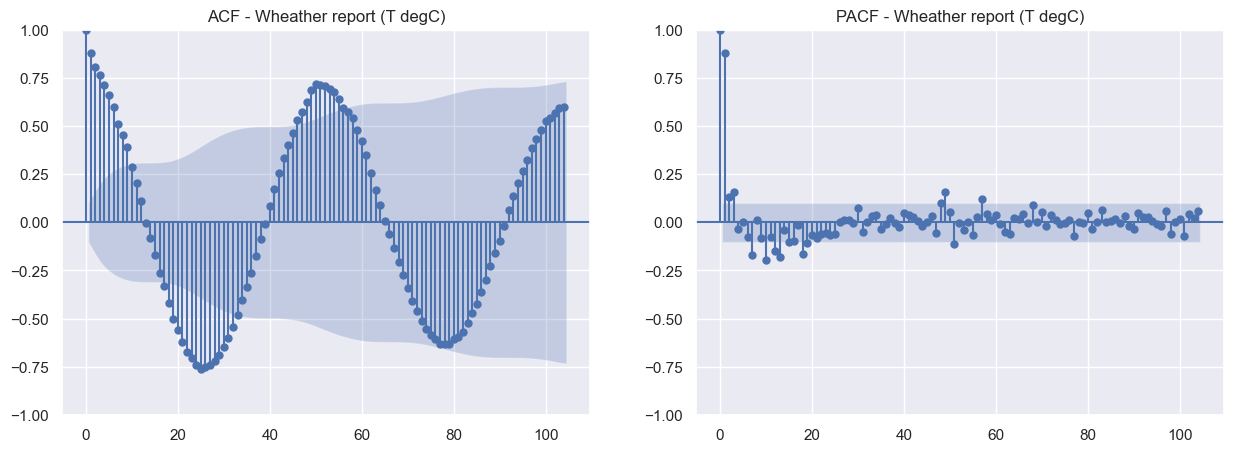

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
plot_acf(temp, lags=104, ax=ax[0], title='ACF - Wheather report (T degC)')
plot_pacf(temp, lags=104, ax=ax[1], title='PACF - Wheather report (T degC)')
plt.show()

we can see that the acf increase and decrease so it is means that there are a presence of a trend (start with positive values and slowly decriseas the lags increse; it is also true at the lag 25/26 from negative to positive ?? seconda osservazione penso sia sbagliata perchè in generale + lag mettiamo più si restinge in generale provare a mettere 208) and seasonality (the ACF are larger for the leasonal lags?? secondo me posso dire che semplicemente si vede una ripetizione di certi picchi che è uguale a 52) (SCRIVERE MEGLIO)

### ADF and KPSS

In [33]:
# ADF test
adf_test = adfuller(temp,autolag='AIC') 
print('ADF Statistic:', adf_test[0])
print('p-value - ADF: ', adf_test[1])
print('------------------------------')

# p > 0.05 --> We reject the null hypothesis, meaning the data is not-stationary, as expected from the plot

# KPSS test option 1
kpss_test = kpss(temp, regression='c', nlags='auto', store=True) 
print('KPSS Statistic - c:', kpss_test[0])
print('p-value - c: ', kpss_test[1])
print('------------------------------')

# p < 0.05 --> We reject the null hypothesis, meaning the data is non-stationary.
# This because the "c" option tests for stationarity around a ‘mean’ only

# KPSS test option 2
kpss_test = kpss(temp, regression='ct', nlags='auto', store=True)
print('KPSS Statistic - ct:', kpss_test[0])
print('p-value - ct: ', kpss_test[1])
print('------------------------------')

# p > 0.05 --> We can not reject the null hypothesis, meaning the data is trend stationary

ADF Statistic: -7.945514086336788
p-value - ADF:  3.2279831966229144e-12
------------------------------
KPSS Statistic - c: 0.10545784665825468
p-value - c:  0.1
------------------------------
KPSS Statistic - ct: 0.020274605447635607
p-value - ct:  0.1
------------------------------


C:\Users\elped\AppData\Local\Temp\ipykernel_8264\690312634.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(temp, regression='c', nlags='auto', store=True)
C:\Users\elped\AppData\Local\Temp\ipykernel_8264\690312634.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(temp, regression='ct', nlags='auto', store=True)


In [34]:
def kpss_test(data):
  kpss_out = kpss(data,regression='c', nlags='auto', store=True)
  print('KPSS Statistic:', kpss_out[0])
  print('p-value: ', kpss_out[1])
  if kpss_out[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> unit root, data is not stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is trend stationary')


print('KPSS on Temperature')
kpss_test(temp)


KPSS on Temperature
KPSS Statistic: 0.10545784665825468
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


C:\Users\elped\AppData\Local\Temp\ipykernel_8264\4054022506.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_out = kpss(data,regression='c', nlags='auto', store=True)


In [35]:
# ADF on the different data from previous examples

def adfuller_test(data):
  adf_test = adfuller(data,autolag='AIC') # AIC is the default option
  print('ADF Statistic:', adf_test[0])
  print('p-value: ', adf_test[1])
  print('Critical Values:')
  for key, value in adf_test[4].items():
      print('\t%s: %.3f' % (key, value))
  if adf_test[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is non-stationary')


print('ADF on Temperature')
adfuller_test(temp)
# p > 0.05 --> We cannot reject the null hypothesis (H0), meaning data the data has a unit root and is non-stationary.
# p <= 0.05 --> We reject the null hypothesis (H0), meaning data the data has not a unit root and is stationary.

ADF on Temperature
ADF Statistic: -7.945514086336788
p-value:  3.2279831966229144e-12
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
We can reject the null hypothesis (H0) --> data is stationary


La time series risulta stazionaria

Come ???? non ce seasonality?? non ho capito qualcosa
RICONTROLLARE

see differencing and logarithm transformation

## Seasonality

try to remove seasonality, but i think this is useless becouse is already stationary the ts

In [36]:
temp_diff_seas = temp.diff(52).dropna()

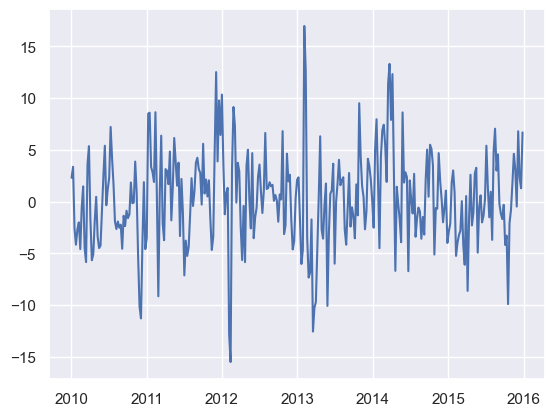

In [37]:
plt.figure()
plt.plot(temp_diff_seas)
plt.show()

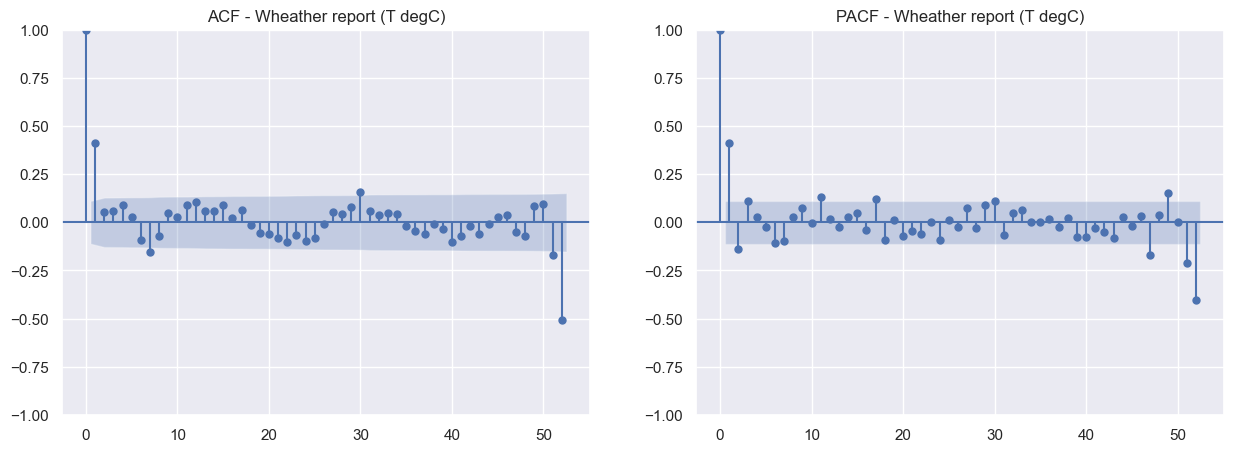

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
plot_acf(temp_diff_seas, lags=52, ax=ax[0], title='ACF - Wheather report (T degC)')
plot_pacf(temp_diff_seas, lags=52, ax=ax[1], title='PACF - Wheather report (T degC)')
plt.show()

In [39]:
'''# ADF test
adf_test = adfuller(temp_diff,autolag='AIC') 
print('ADF Statistic:', adf_test[0])
print('p-value - ADF: ', adf_test[1])
print('------------------------------')

# p > 0.05 --> We reject the null hypothesis, meaning the data is not-stationary, as expected from the plot

# KPSS test option 1
kpss_test = kpss(temp_diff, regression='c', nlags='auto', store=True) 
print('KPSS Statistic - c:', kpss_test[0])
print('p-value - c: ', kpss_test[1])
print('------------------------------')

# p < 0.05 --> We reject the null hypothesis, meaning the data is non-stationary.
# This because the "c" option tests for stationarity around a ‘mean’ only

# KPSS test option 2
kpss_test = kpss(temp_diff, regression='ct', nlags='auto', store=True)
print('KPSS Statistic - ct:', kpss_test[0])
print('p-value - ct: ', kpss_test[1])
print('------------------------------')

# p > 0.05 --> We can not reject the null hypothesis, meaning the data is trend stationary'''

'# ADF test\nadf_test = adfuller(temp_diff,autolag=\'AIC\') \nprint(\'ADF Statistic:\', adf_test[0])\nprint(\'p-value - ADF: \', adf_test[1])\nprint(\'------------------------------\')\n\n# p > 0.05 --> We reject the null hypothesis, meaning the data is not-stationary, as expected from the plot\n\n# KPSS test option 1\nkpss_test = kpss(temp_diff, regression=\'c\', nlags=\'auto\', store=True) \nprint(\'KPSS Statistic - c:\', kpss_test[0])\nprint(\'p-value - c: \', kpss_test[1])\nprint(\'------------------------------\')\n\n# p < 0.05 --> We reject the null hypothesis, meaning the data is non-stationary.\n# This because the "c" option tests for stationarity around a ‘mean’ only\n\n# KPSS test option 2\nkpss_test = kpss(temp_diff, regression=\'ct\', nlags=\'auto\', store=True)\nprint(\'KPSS Statistic - ct:\', kpss_test[0])\nprint(\'p-value - ct: \', kpss_test[1])\nprint(\'------------------------------\')\n\n# p > 0.05 --> We can not reject the null hypothesis, meaning the data is trend s

to check the seasonality for the temperature see the chapter Frequency Analysis -> PSD

## Decomposition

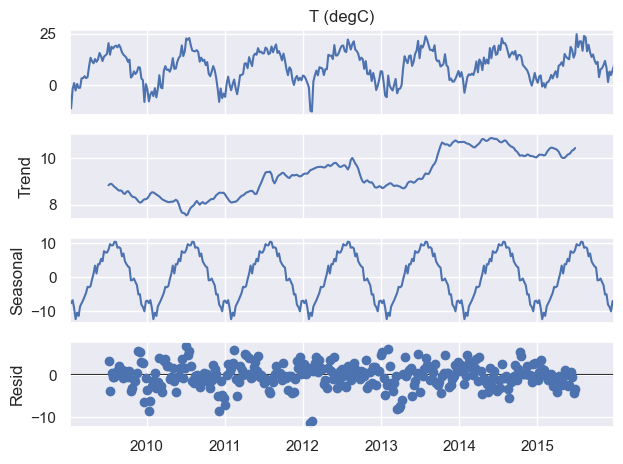

In [40]:
decompose_data_add = seasonal_decompose(Weather_data_wk_train['T (degC)'], model='additive', period = int(dizio_period['T (degC)'])) # period is automatically set to 12, considering the monthly data
decompose_data_add.plot()
plt.show()

simao sicuri che non sia una roba della frequency analysis??

# FORECASTING

stampare i plot diagnosis!!

In [41]:
# feature to forecast
feature = 'T (degC)'

In [42]:
#final test and train
train = Weather_data_wk_train[feature]
#display(train)
test = Weather_data_wk_test[feature]
#display(test)

In [43]:
#df to take track of the precision of the models
df_accuracy = pd.DataFrame(columns=['Model','AIC','RMSE','MAE'])
display(df_accuracy)

,Model,AIC,RMSE,MAE


AUTOMATIZZARE LA SCELTA DEL PERIODO!!!

## Simple forecasting approaches

### Mean method

In [ ]:
# 1) Mean method --> the forecasts of all future values are equal to the average of the historical data
model_average = HistoricAverage()
model_average = model_average.fit(train)
#forecast_values = model_average.prediction_intervals(start = test.index[0], end=test.index[-1])
forecast_values = model_average.predict(len(test))
#display(forecast_values['mean'])

#time
#start_date = test.index[0]
#end_date = test.index[-1]
#final_date_pred = pd.date_range(start=start_date, end=end_date, freq = 'W')
#final_date_pred = test.index

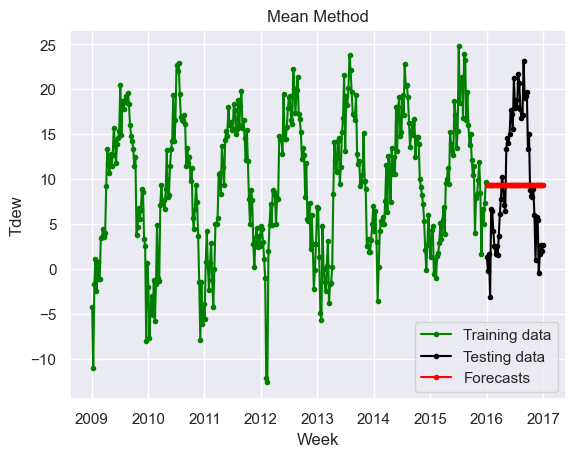

In [90]:
plt.figure()
plt.plot(train, color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
plt.plot(test.index,forecast_values['mean'], color='red', marker = '.', label='Forecasts' )
plt.xlabel('Week')
plt.ylabel('Tdew')
plt.title('Mean Method')
plt.legend()
plt.show()

### Naive method

In [94]:
#Naive Method --> we simply set all forecasts to be the value of the last observation
# Model, fitting and forecasting (20 samples)
model_Naive = Naive()
model_Naive = model_Naive.fit(train)
forecast_values = model_Naive.predict(len(test)) # same forecasting horizon as before
# forecast_values: Dictionary with entries mean for point predictions
#display(forecast_values['mean'])


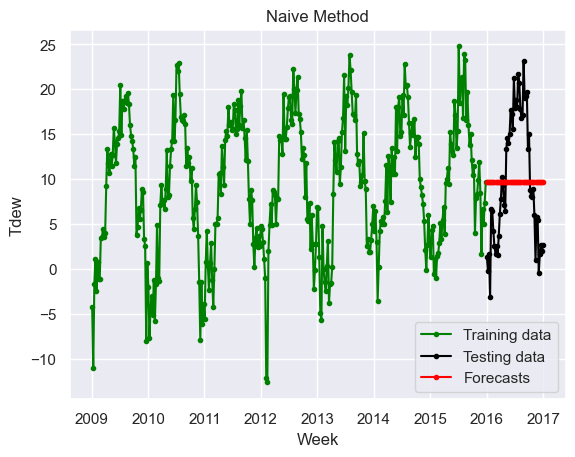

In [95]:
plt.figure()
plt.plot(train, color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
plt.plot(test.index, forecast_values['mean'], color='red', marker = '.', label='Forecasts' )
plt.xlabel('Week')
plt.ylabel('Tdew')
plt.title('Naive Method')
plt.legend()
plt.show()

### Seasonal Naive method

### Drift method

## Exponential Smoothing Additive Single

In [44]:
#apply trasformation on the train
#train = np.log(train)

#cration of the model
modelESAS = ETSModel(train, error='add').fit()
#make the prediction
pred = modelESAS.get_prediction(start=test.index[0], end=test.index[-1])
#summary of the model
df_modelESAS = pred.summary_frame()
#take the forecasting
forecasts = df_modelESAS['mean']

#df_modelESAS = np.exp(df_modelESAS) #nel caso venga fatto il log!!

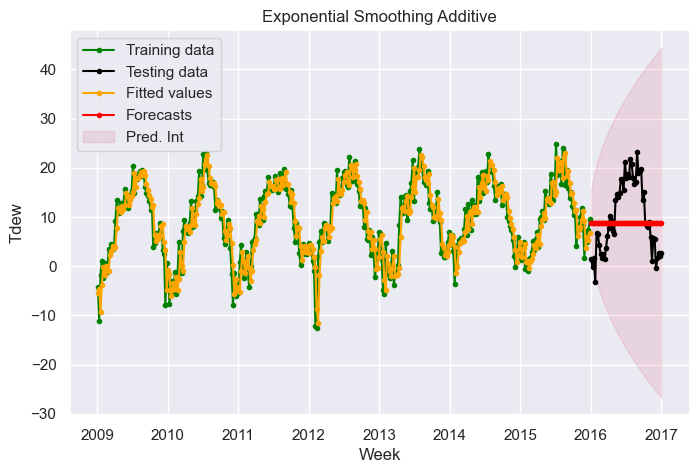

In [45]:
# Visualization
plt.figure(figsize=(8,5))
#plt.plot(np.exp(train), color='green',marker = '.',label='Training data')
plt.plot(train, color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
#plt.plot(np.exp(modelESAS.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(modelESAS.fittedvalues,color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts, color='red', marker = '.', label='Forecasts')
plt.fill_between(df_modelESAS.index, df_modelESAS['pi_lower'], df_modelESAS['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Week')
plt.ylabel('Tdew')
plt.title('Exponential Smoothing Additive')
plt.legend()
plt.show()

In [46]:
#save the accuracy
df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'Exponentian Smoothing Additive Single', 'AIC':modelESAS.aic, 'RMSE':root_mean_squared_error(test, df_modelESAS['mean']), 'MAE':mean_absolute_error(test, df_modelESAS['mean'])},index=[0])], ignore_index=True)

C:\Users\elped\AppData\Local\Temp\ipykernel_8264\2578225472.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'Exponentian Smoothing Additive Single', 'AIC':modelESAS.aic, 'RMSE':root_mean_squared_error(test, df_modelESAS['mean']), 'MAE':mean_absolute_error(test, df_modelESAS['mean'])},index=[0])], ignore_index=True)


## Exponential Smoothing Additive Double

In [47]:
#apply trasformation on the train
#train = np.log(train)

#cration of the model
modelESADouble = ETSModel(train, error='add', trend = 'add', damped_trend=False).fit()
#make the prediction
pred = modelESADouble.get_prediction(start=test.index[0], end=test.index[-1])
#summary of the model
df_modelESADouble = pred.summary_frame()
#take the forecasting
forecasts = df_modelESADouble['mean']

#df_modelESADouble = np.exp(df_modelESADouble) #nel caso venga fatto il log!!

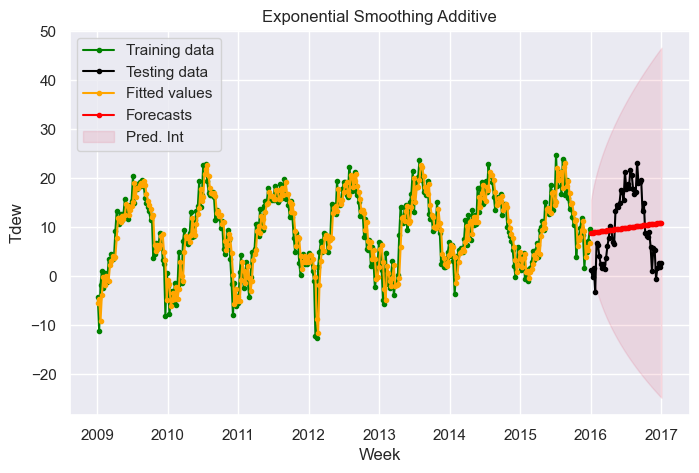

In [48]:
# Visualization
plt.figure(figsize=(8,5))
#plt.plot(np.exp(train), color='green',marker = '.',label='Training data')
plt.plot(train, color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
#plt.plot(np.exp(modelESADouble.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(modelESADouble.fittedvalues,color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts, color='red', marker = '.', label='Forecasts')
plt.fill_between(df_modelESADouble.index, df_modelESADouble['pi_lower'], df_modelESADouble['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Week')
plt.ylabel('Tdew')
plt.title('Exponential Smoothing Additive')
plt.legend()
plt.show()

In [49]:
#save the accuracy
df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'Exponentian Smoothing Additive Double', 'AIC':modelESADouble.aic, 'RMSE':root_mean_squared_error(test, df_modelESADouble['mean']), 'MAE':mean_absolute_error(test, df_modelESADouble['mean'])},index=[0])], ignore_index=True)

## Exponential Smoothing Additive Double Damped Trend True

In [50]:
#apply trasformation on the train
#train = np.log(train)

#cration of the model
modelESADDouble = ETSModel(train, error='add', trend = 'add', damped_trend=True).fit()
#make the prediction
pred = modelESADDouble.get_prediction(start=test.index[0], end=test.index[-1])
#summary of the model
df_modelESADDouble = pred.summary_frame()
#take the forecasting
forecasts = df_modelESADDouble['mean']

#df_modelESADDouble = np.exp(df_modelESADDouble) #nel caso venga fatto il log!!

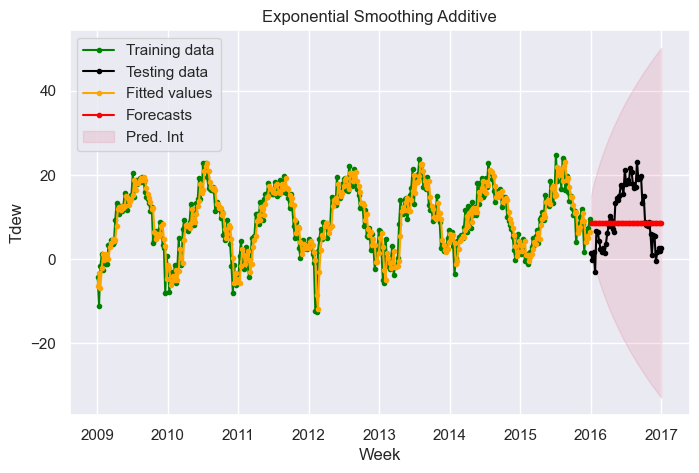

In [51]:
# Visualization
plt.figure(figsize=(8,5))
#plt.plot(np.exp(train), color='green',marker = '.',label='Training data')
plt.plot(train, color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
#plt.plot(np.exp(modelESADDouble.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(modelESADDouble.fittedvalues,color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts, color='red', marker = '.', label='Forecasts')
plt.fill_between(df_modelESADDouble.index, df_modelESADDouble['pi_lower'], df_modelESADDouble['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Week')
plt.ylabel('Tdew')
plt.title('Exponential Smoothing Additive')
plt.legend()
plt.show()

like we can see from the plot it is like the ESA Single 

In [52]:
#save the accuracy
df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'Exponentian Smoothing Additive Double Damped True', 'AIC':modelESADDouble.aic, 'RMSE':root_mean_squared_error(test, df_modelESADDouble['mean']), 'MAE':mean_absolute_error(test, df_modelESADDouble['mean'])},index=[0])], ignore_index=True)

## Exponential Smoothing Additive

NOTE: Models with multiplicative errors are useful for strictly positive data, but are not numerically stable with data containing zeros or negative values like in this case.
So we will test EST(A,A,Ad) and EST(A,A,A)

In [53]:
#apply trasformation on the train
#train = np.log(train)

#cration of the model
modelESA = ETSModel(train, error='add', trend = 'add', seasonal='add', seasonal_periods=52, damped_trend=False).fit()
#make the prediction
pred = modelESA.get_prediction(start=test.index[0], end=test.index[-1])
#summary of the model
df_modelESA = pred.summary_frame()
#take the forecasting
forecasts = df_modelESA['mean']

#df_modelESA = np.exp(df_modelESA) #nel caso venga fatto il log!!

c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


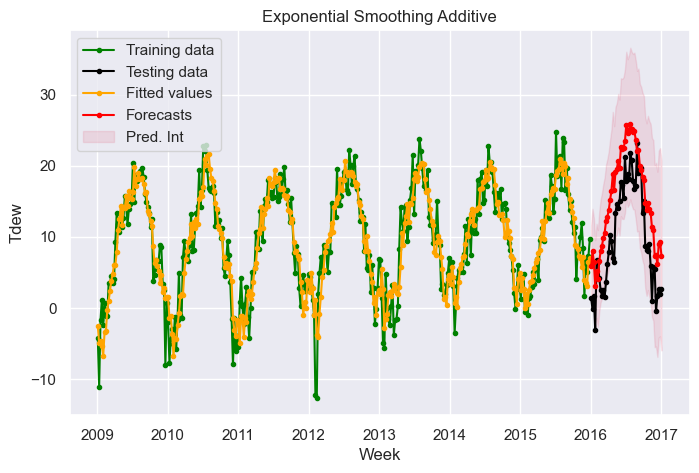

In [54]:
# Visualization
plt.figure(figsize=(8,5))
#plt.plot(np.exp(train), color='green',marker = '.',label='Training data')
plt.plot(train, color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
#plt.plot(np.exp(modelESA.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(modelESA.fittedvalues,color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts, color='red', marker = '.', label='Forecasts')
plt.fill_between(df_modelESA.index, df_modelESA['pi_lower'], df_modelESA['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Week')
plt.ylabel('Tdew')
plt.title('Exponential Smoothing Additive')
plt.legend()
plt.show()

In [55]:
#save the accuracy
df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'Exponentian Smoothing Additive', 'AIC':modelESA.aic, 'RMSE':root_mean_squared_error(test, df_modelESA['mean']), 'MAE':mean_absolute_error(test, df_modelESA['mean'])},index=[0])], ignore_index=True)

## Exponential Smoothing Addictive Damped Trend True

In [56]:
#apply trasformation on the train
#train = np.log(train)

#cration of the model
modelESAd = ETSModel(train, error='add', trend = 'add', seasonal='add', seasonal_periods=52, damped_trend=True).fit()
#make the prediction
pred = modelESAd.get_prediction(start=test.index[0], end=test.index[-1])
#summary of the model
df_modelESAd = pred.summary_frame()
#take the forecasting
forecasts = df_modelESAd['mean']

#df_modelESAd = np.exp(df_modelESAd) #nel caso venga fatto il log!!


c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [76]:
#df_modelESAd

,mean,pi_lower,pi_upper
2016-01-03,5.290284,-0.345352,10.925920
2016-01-10,7.121655,1.357697,12.885613
2016-01-17,5.358274,-0.531227,11.247775
2016-01-24,1.869241,-4.143195,7.881676
2016-01-31,3.825641,-2.307275,9.958557
2016-02-07,2.627713,-3.623369,8.878795
2016-02-14,4.933936,-1.433127,11.300998
2016-02-21,6.321225,-0.159746,12.802197
2016-02-28,7.012275,0.419359,13.605192
2016-03-06,8.048051,1.345055,14.751047


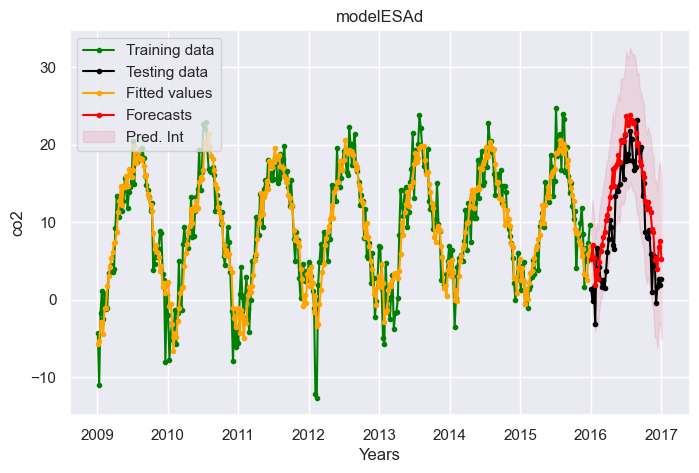

In [57]:
# Visualization #PER IL PLTO RI TRASFORMARE I DATI CON L'ESPONENZIALE!!!!!
plt.figure(figsize=(8,5))
plt.plot((train), color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
plt.plot((modelESAd.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts, color='red', marker = '.', label='Forecasts')
plt.fill_between(df_modelESAd.index, df_modelESAd['pi_lower'], df_modelESAd['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Years')
plt.ylabel('co2')
plt.title('modelESAd')
plt.legend()
plt.show()

In [58]:
#save the accuracy
df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'Exponentian Smoothing AD', 'AIC':modelESAd.aic, 'RMSE':root_mean_squared_error(test, df_modelESAd['mean']), 'MAE':mean_absolute_error(test, df_modelESAd['mean'])},index=[0])], ignore_index=True)

## Manual SARIMA

so we have to decide the parameter for the AR part, MA part, I and Seasonal.
From the last points we know that:
-   S = 52
-   AR (p) = 0
-   I = 0 -> perchè è già stazionario
-   MA (q) = 1

in generale:
-   non seasonal component (p,d,q) -> (0,0,0)
-   seasonl component (P,D,Q) -> (0,0,0)
-   seasonality m = 52


rivedere come capire manaulmente i valori per AR and MA, INSERIRLI NELLA PARTE DI ACF AND PACF,
VEDERE ANCHE CON ALE COME LEGGERE ACF AND PSCF DALLA LEZIONE 10!!

In [59]:
#model_SARIMA = SARIMA()

## Auto SARIMA (Auto_Arima)

In [60]:
stepwise_model = auto_arima(train, start_p=0, start_q=0, d=0,
                           max_p=5, max_q=5, m=52,
                           start_P=0, start_Q=0, max_P = 5, max_Q = 5, D = 0, seasonal=True,
                           trace=True, information_criterion='aic',
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True) #TRUE altrimenti ci impiega troppo #ATTENZIONE PROVARE A MAETTERE D=1 E d=0

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2506.210, Time=0.11 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=1947.682, Time=126.98 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=2142.777, Time=111.02 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2849.806, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=1950.240, Time=0.16 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=117.58 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=6.42 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=1949.098, Time=1.51 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=1935.467, Time=26.06 sec
 ARIMA(1,0,0)(3,0,1)[52] intercept   : AIC=inf, Time=288.45 sec
 ARIMA(1,0,0)(2,0,2)[52] intercept   : AIC=1936.279, Time=36.59 sec
 ARIMA(1,0,0)(1,0,2)[52] intercept   : AIC=1937.126, Time=32.93 sec
 ARIMA(1,0,0)(3,0,0)[52] intercept   : AIC=inf, Time=33.05 sec
 ARIMA(1,0,0)(3,0,2)[52] intercept   : AIC=inf, Time=369.33 sec
 ARIMA(0,0,0)(2,0,1)[52] inter

In [63]:
#best oarameters
#Best model:  ARIMA(3,0,0)(2,0,0)[52] intercept
(p, d, q) = stepwise_model.order
(P, D, Q, S) = stepwise_model.seasonal_order

In [71]:
#creation of the model SARIMA
model_SARIMA = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,S)).fit()

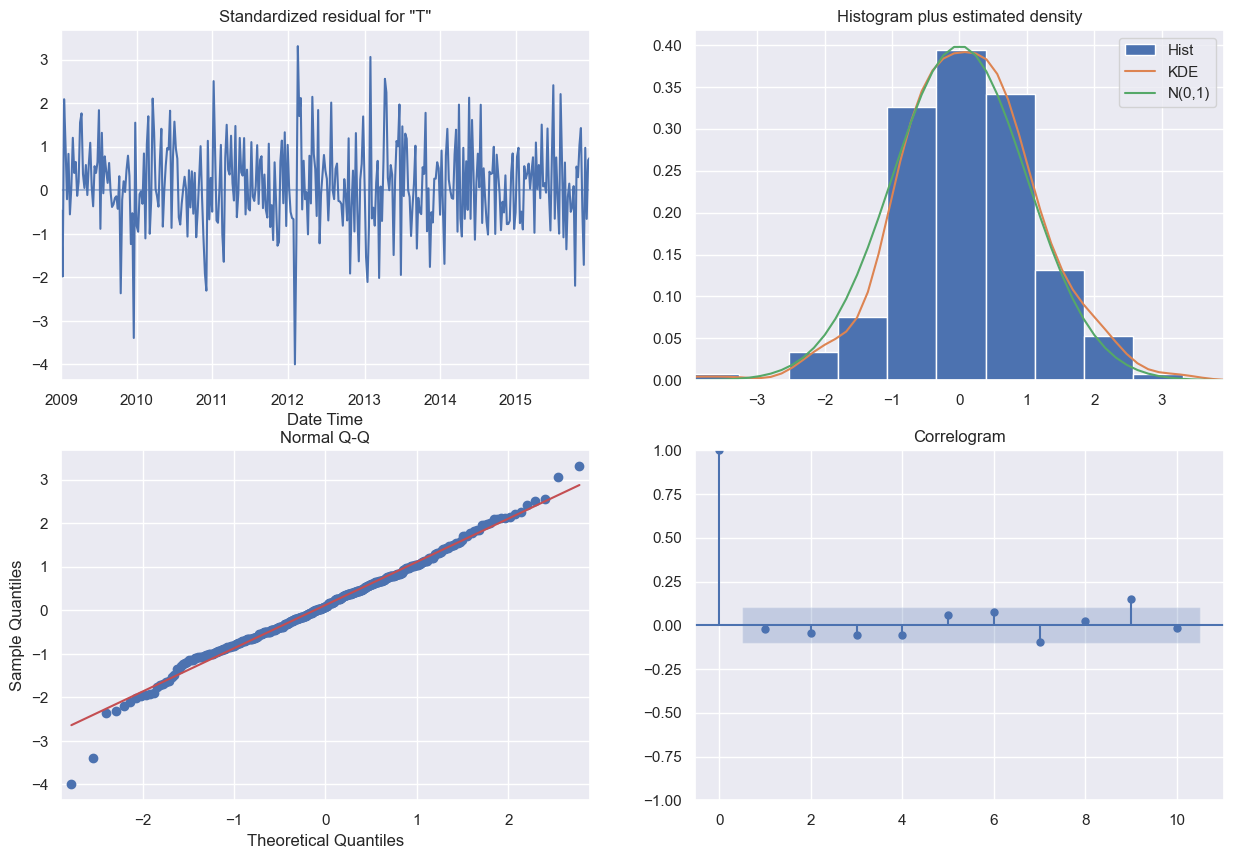

In [72]:
model_SARIMA.plot_diagnostics(figsize=(15,10))
plt.show()

form the diagnosis we can see that the residual are similar to a normal so there aren't missing time pattern

In [73]:
#forecasting
pred = model_SARIMA.get_prediction(start=test.index[0], end=test.index[-1])
#summary of the model
df_modelSARIMA = pred.summary_frame()
#take the forecasting
forecasts = df_modelSARIMA['mean']


In [80]:
df_modelSARIMA['mean']

2016-01-03     7.502404
2016-01-10     7.871560
2016-01-17     7.341756
2016-01-24     4.893081
2016-01-31     5.687944
2016-02-07     6.057977
2016-02-14     6.510134
2016-02-21     6.286016
2016-02-28     6.449138
2016-03-06     6.460557
2016-03-13     6.600804
2016-03-20     7.623260
2016-03-27     6.550102
2016-04-03     7.309538
2016-04-10     7.729868
2016-04-17     6.832709
2016-04-24     8.208552
2016-05-01     7.162173
2016-05-08     8.337954
2016-05-15     7.604719
2016-05-22     9.006711
2016-05-29     7.763172
2016-06-05     9.626902
2016-06-12     9.548457
2016-06-19     7.934962
2016-06-26     8.216473
2016-07-03    10.440698
2016-07-10     8.924586
2016-07-17    10.500745
2016-07-24     9.897271
2016-07-31     9.155695
2016-08-07     9.854575
2016-08-14     9.052970
2016-08-21     7.387019
2016-08-28     8.118724
2016-09-04     7.753994
2016-09-11     7.078645
2016-09-18     7.585954
2016-09-25     6.171233
2016-10-02     6.349922
2016-10-09     6.453486
2016-10-16     5

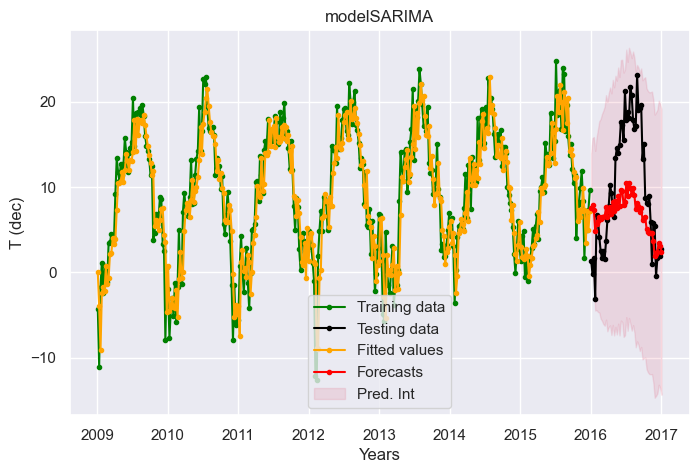

In [ ]:
# Visualization #PER IL PLTO RI TRASFORMARE I DATI CON L'ESPONENZIALE!!!!!
plt.figure(figsize=(8,5))
plt.plot((train), color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
plt.plot((model_SARIMA.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts, color='red', marker = '.', label='Forecasts')
plt.fill_between(df_modelSARIMA.index, df_modelSARIMA['mean_ci_lower'], df_modelSARIMA['mean_ci_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Years')
plt.ylabel('T (dec)')
plt.title('modelSARIMA')
plt.legend()
plt.show()

#ATTENZIONE RIVEDERE!!!!!

In [82]:
df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'Auto_Arima + Sarima', 'AIC':model_SARIMA.aic, 'RMSE':root_mean_squared_error(test, df_modelSARIMA['mean']), 'MAE':mean_absolute_error(test, df_modelSARIMA['mean'])},index=[0])], ignore_index=True)

## SARIMAX

##  Dispaly accuracy

In [83]:
df_accuracy

,Model,AIC,RMSE,MAE
0,Exponentian Smoothing Additive Single,1945.438950,7.263913,6.306063
1,Exponentian Smoothing Additive Double,1949.383951,7.100954,6.359960
2,Exponentian Smoothing Additive Double Damped True,1948.273850,7.279968,6.287037
3,Exponentian Smoothing Additive,1932.582440,6.123421,5.627138
4,Exponentian Smoothing AD,1924.839365,4.519451,4.055855
5,Auto_Arima + Sarima,1924.952286,6.703710,5.489217
